# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
from scipy.integrate import quad
from scipy.signal import savgol_filter, correlate, fftconvolve
from scipy.sparse import csr_matrix, dia_matrix, csc_matrix, coo_matrix
from scipy.spatial import ConvexHull
from scipy import fftpack
import torch
from functools import reduce
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'torch device: {device}')

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.pylab as plb

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
import alens_analysis.chromatin.chrom_poly_stats as cps
import alens_analysis.helpers as ahlp
import alens_analysis.read_func as arf
from alens_analysis import cluster_analysis as cla
from alens_analysis import physical_scales as ps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'
test_dir_path = Path.home() / 'ceph/DATA/Chromatin/DynCondPaper/testing'

torch device: cuda


### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)
        

# Data

## Steric pinned simulation

In [3]:
def get_run_param(h5_path, param):
    with h5py.File(h5_path, 'r') as h5_data:
        rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
        return rparams[param]
data_path = test_dir_path / '23-10-12_line1600_scan5.1_dt5e-6_5e-4_5umPin/simulations/'
h5_path_list = sorted([h5_path for h5_path in data_path.glob('*/analysis/raw*.h5')], key=lambda x: get_run_param(x, 'dt'))
dt_list = [get_run_param(h5_path, 'dt') for h5_path in h5_path_list]
print(h5_path_list)
print(dt_list)

[PosixPath('/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/testing/23-10-12_line1600_scan5.1_dt5e-6_5e-4_5umPin/simulations/dt5e-06/analysis/raw_dt5e-06.h5'), PosixPath('/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/testing/23-10-12_line1600_scan5.1_dt5e-6_5e-4_5umPin/simulations/dt1e-05/analysis/raw_dt1e-05.h5'), PosixPath('/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/testing/23-10-12_line1600_scan5.1_dt5e-6_5e-4_5umPin/simulations/dt5e-05/analysis/raw_dt5e-05.h5'), PosixPath('/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/testing/23-10-12_line1600_scan5.1_dt5e-6_5e-4_5umPin/simulations/dt0.0001/analysis/raw_dt0.h5'), PosixPath('/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/testing/23-10-12_line1600_scan5.1_dt5e-6_5e-4_5umPin/simulations/dt0.0005/analysis/raw_dt0.h5')]
[5e-06, 1e-05, 5e-05, 0.0001, 0.0005]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


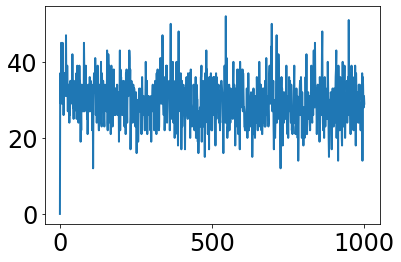

In [4]:
data_path = test_dir_path / '23-10-12_line1600_scan5.1_dt5e-6_5e-4_5umPin/simulations/dt0.0005/analysis/raw_dt0.h5'

# collect hdf5 file
with h5py.File(data_path, 'r') as h5_data:
    rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
    pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])

    time_arr = h5_data['time'][1:None]
    dt = time_arr[2] - time_arr[1]

    sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    tcom_arr = torch.from_numpy(com_arr).to(device)
    bin_arr = torch.zeros(time_arr.size).to(device)
    for i in range(0, time_arr.size):
            sep_mat = torch.linalg.norm(tcom_arr[:, np.newaxis, :, i] - tcom_arr[np.newaxis, :, :, i], dim=2)
            bin_arr[i] = torch.sum(sep_mat < .01)/2. - 800
    plt.plot(bin_arr.cpu().numpy())
   
    
    


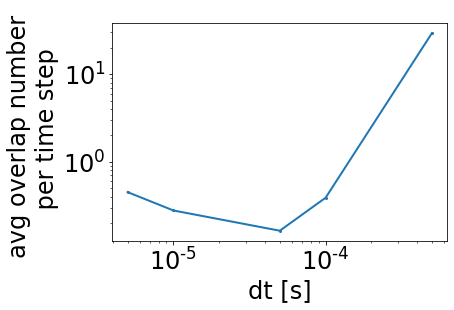

In [5]:
overlap_list = []
for dt, h5_path in zip(dt_list, h5_path_list):
    with h5py.File(h5_path, 'r') as h5_data:
        rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
        pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])

        time_arr = h5_data['time'][1:None]
        dt = time_arr[2] - time_arr[1]

        sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        tcom_arr = torch.from_numpy(com_arr).to(device)
        bin_arr = torch.zeros(time_arr.size).to(device)
        for i in range(0, time_arr.size):
                sep_mat = torch.linalg.norm(tcom_arr[:, np.newaxis, :, i] - tcom_arr[np.newaxis, :, :, i], dim=2)
                bin_arr[i] = torch.sum(sep_mat < .01)/2. - 800
    overlap_list += [bin_arr.sum()]

_ = plt.loglog(dt_list, np.array(overlap_list)/time_arr.size, marker='o')
_ = plt.xlabel('dt [s]')
_ = plt.ylabel('avg overlap number \n per time step')

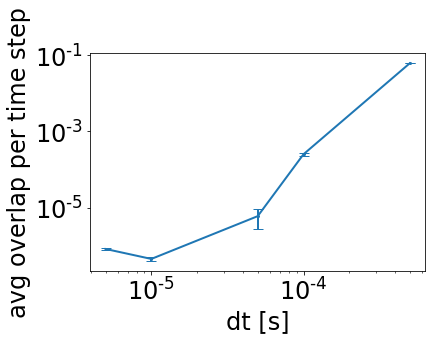

In [6]:
overlap_list = []
overlap_std_list = []
for dt, h5_path in zip(dt_list, h5_path_list):
    with h5py.File(h5_path, 'r') as h5_data:
        rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
        pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])

        time_arr = h5_data['time'][1:None]
        dt = time_arr[2] - time_arr[1]

        sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        tcom_arr = torch.from_numpy(com_arr).to(device)
        bin_arr = torch.zeros(time_arr.size).to(device)
        for i in range(0, time_arr.size):
                sep_mat = torch.linalg.norm(tcom_arr[:, np.newaxis, :, i] - tcom_arr[np.newaxis, :, :, i], dim=2)
                bin_arr[i] = torch.sum(.01-(sep_mat[sep_mat < .01]))/2. - 8
    overlap_list += [bin_arr.mean().to('cpu').numpy()]
    overlap_std_list += [bin_arr.std().to('cpu').numpy()]
overlap_list = np.array(overlap_list)
overlap_std_list = np.array(overlap_std_list) 

_ = plt.errorbar(dt_list, overlap_list, yerr=overlap_std_list/np.sqrt(time_arr.size),  marker='o', capsize=5)
_ = plt.yscale('log')
_ = plt.xscale('log')
_ = plt.xlabel('dt [s]')
_ = plt.ylabel('avg overlap per time step')

### Distance distribution test

In [7]:
def get_extend_potential_theory(x_arr, kappa, b):
    sigma2 = .00411/kappa
    # partition_func = np.sqrt(np.pi*np.power(sigma2,3)/2.) 
    prob_func = np.power(x_arr, 2)*np.exp(-np.power(x_arr-b,2)/(2.*sigma2))
    partition_func = np.sum(prob_func)*(x_arr[1]-x_arr[0])
    prob_func = prob_func/partition_func
    return prob_func

dt = 5e-06
dt = 1e-05
dt = 5e-05
dt = 0.0001
dt = 0.0005


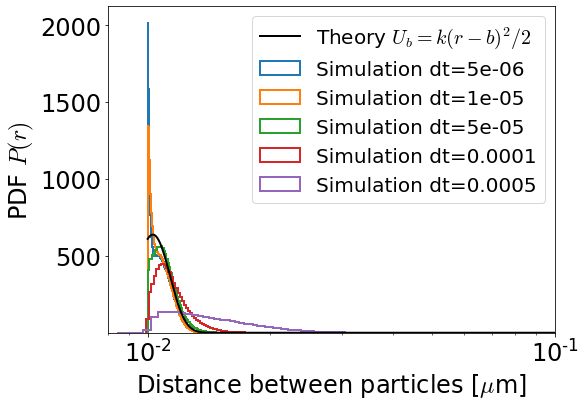

In [9]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

x_arr = np.linspace(.01, .14, 5000)
ks = get_run_param(h5_path_list[0], 'extendLinkKappa')
_ = axarr.plot(x_arr, get_extend_potential_theory(x_arr, ks, .0101), color='black', label='Theory $U_b = k(r-b)^2/2$')
for dt, h5_path in zip(dt_list, h5_path_list):
    try: 
        with h5py.File(h5_path, 'r') as h5_data:
            run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
            print(f'dt = {dt}')
            time_arr = h5_data['time'][:] 
            # Load in sylinder data
            try:
                sy_dat = h5_data['raw_data/sylinders'][...]
            except:
                print(f'dt = {dt} not made.')
                continue
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            tcom_arr = torch.from_numpy(com_arr).to(device)
            # Average over all the trimers
            dist_arr = torch.linalg.norm((tcom_arr[1:, :, :] - tcom_arr[:-1, :, :]), dim=1).to('cpu').numpy()

            _ = axarr.hist(dist_arr.flatten(), bins=100, density=True, label=f'Simulation dt={dt}', histtype='step', linewidth=2)
    except:
        pass
_ = axarr.set_xlabel('Distance between particles [$\mu$m]')
_ = axarr.set_ylabel('PDF $P(r)$')
_ = axarr.set_xscale('log')
# _ = axarr.set_yscale('log')
_ = axarr.legend()
# _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))

_ = axarr.set_xlim(0.008, .1)
_ = axarr.set_ylim(1)
# fig.tight_layout()

dt = 5e-06
dt = 1e-05
dt = 5e-05
dt = 0.0001
dt = 0.0005


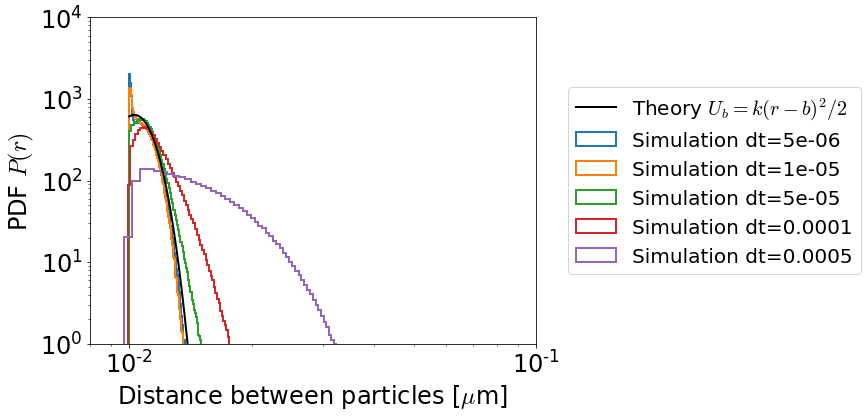

In [11]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

x_arr = np.linspace(.01, .14, 5000)
ks = get_run_param(h5_path_list[0], 'extendLinkKappa')
_ = axarr.plot(x_arr, get_extend_potential_theory(x_arr, ks, .0101), color='black', label='Theory $U_b = k(r-b)^2/2$')
for dt, h5_path in zip(dt_list, h5_path_list):
    try: 
        with h5py.File(h5_path, 'r') as h5_data:
            run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
            print(f'dt = {dt}')
            time_arr = h5_data['time'][:] 
            # Load in sylinder data
            try:
                sy_dat = h5_data['raw_data/sylinders'][...]
            except:
                print(f'dt = {dt} not made.')
                continue
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            tcom_arr = torch.from_numpy(com_arr).to(device)
            # Average over all the trimers
            dist_arr = torch.linalg.norm((tcom_arr[1:, :, :] - tcom_arr[:-1, :, :]), dim=1).to('cpu').numpy()

            _ = axarr.hist(dist_arr.flatten(), bins=100, density=True, label=f'Simulation dt={dt}', histtype='step', linewidth=2)
    except:
        pass
_ = axarr.set_xlabel('Distance between particles [$\mu$m]')
_ = axarr.set_ylabel('PDF $P(r)$')
_ = axarr.set_xscale('log')
_ = axarr.set_yscale('log')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))

_ = axarr.set_xlim(0.008, .1)
_ = axarr.set_ylim(1, 1e4)
# fig.tight_layout()

## No steric simulation
For testing the spring stretch and make sure it aligns with theory. Distribution should follow and analytic result. To save a tad bit of time I'm going to integrate numerically. I'll write down the solution later.

In [60]:
def get_extend_potential_theory(x_arr, kappa, b):
    sigma2 = .00411/kappa
    # partition_func = np.sqrt(np.pi*np.power(sigma2,3)/2.) 
    prob_func = np.power(x_arr, 2)*np.exp(-np.power(x_arr-b,2)/(2.*sigma2))
    partition_func = np.sum(prob_func)*(x_arr[1]-x_arr[0])
    prob_func = prob_func/partition_func
    return prob_func

In [61]:
def get_run_param(h5_path, param):
    with h5py.File(h5_path, 'r') as h5_data:
        rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
        return rparams[param]
data_path = test_dir_path / '23-10-12_line1600_scan5.1_dt5e-6_5e-4_5umPin_no_steric/simulations/'
# h5_path_list = sorted([h5_path for h5_path in data_path.glob('*/analysis/raw*.h5')], key=lambda x: get_run_param(x, 'dt'))
h5_path_list = []
for h5_path in data_path.glob('*/analysis/raw*.h5'):
    try:
        dt = get_run_param(h5_path, 'dt')
    except:
        continue
    h5_path_list += [h5_path]
h5_path_list = sorted(h5_path_list, key=lambda x: get_run_param(x, 'dt'))
dt_list = [get_run_param(h5_path, 'dt') for h5_path in h5_path_list]
print(h5_path_list)
print(dt_list)

[PosixPath('/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/testing/23-10-12_line1600_scan5.1_dt5e-6_5e-4_5umPin_no_steric/simulations/dt5e-06/analysis/raw_dt5e-06.h5'), PosixPath('/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/testing/23-10-12_line1600_scan5.1_dt5e-6_5e-4_5umPin_no_steric/simulations/dt1e-05/analysis/raw_dt1e-05.h5'), PosixPath('/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/testing/23-10-12_line1600_scan5.1_dt5e-6_5e-4_5umPin_no_steric/simulations/dt5e-05/analysis/raw_dt5e-05.h5'), PosixPath('/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/testing/23-10-12_line1600_scan5.1_dt5e-6_5e-4_5umPin_no_steric/simulations/dt0.0001/analysis/raw_dt0.h5'), PosixPath('/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/testing/23-10-12_line1600_scan5.1_dt5e-6_5e-4_5umPin_no_steric/simulations/dt0.0005/analysis/raw_dt0.h5')]
[5e-06, 1e-05, 5e-05, 0.0001, 0.0005]


dt = 5e-06
dt = 1e-05
dt = 5e-05
dt = 0.0001
dt = 0.0005


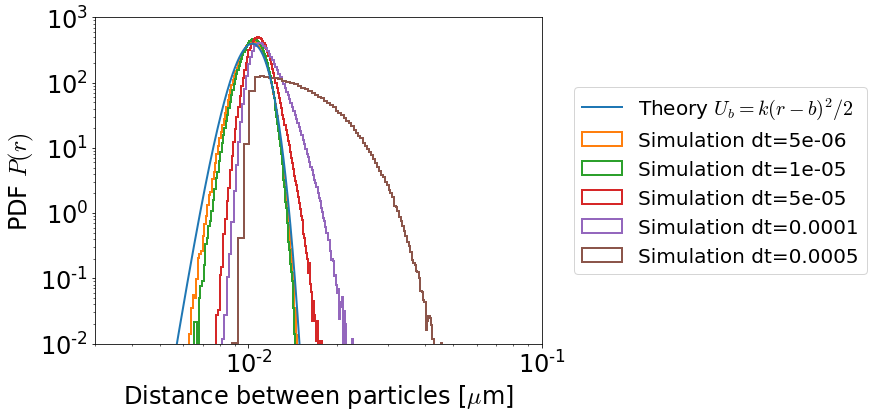

In [62]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

x_arr = np.linspace(0, .14, 5000)
ks = get_run_param(h5_path_list[0], 'extendLinkKappa')
_ = axarr.plot(x_arr, get_extend_potential_theory(x_arr, ks, .0101), label='Theory $U_b = k(r-b)^2/2$')
for dt, h5_path in zip(dt_list, h5_path_list):
    try: 
        with h5py.File(h5_path, 'r') as h5_data:
            run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
            print(f'dt = {dt}')
            time_arr = h5_data['time'][:] 
            # Load in sylinder data
            try:
                sy_dat = h5_data['raw_data/sylinders'][...]
            except:
                print(f'dt = {dt} not made.')
                continue
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            tcom_arr = torch.from_numpy(com_arr).to(device)
            # Average over all the trimers
            dist_arr = torch.linalg.norm((tcom_arr[1:, :, :] - tcom_arr[:-1, :, :]), dim=1).to('cpu').numpy()

            _ = axarr.hist(dist_arr.flatten(), bins=100, density=True, label=f'Simulation dt={dt}', histtype='step', linewidth=2)
    except:
        pass
_ = axarr.set_xlabel('Distance between particles [$\mu$m]')
_ = axarr.set_ylabel('PDF $P(r)$')
_ = axarr.set_xscale('log')
_ = axarr.set_yscale('log')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
_ = axarr.set_xlim(0.003, .1)
_ = axarr.set_ylim(0.01, 1000)

